In [2]:
import arrow as A
import scipy
from PIL import Image
import torch
import torchmetrics
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import itertools
import torchvision
import xarray as xr
import glob

In [3]:
torch.cuda.empty_cache()
print(f'( {torch.cuda.device_count()} ) {torch.cuda.get_device_name(0)} available')

( 1 ) NVIDIA GeForce GTX 1080 Ti available


In [12]:
def bandpass(x):
    mu = np.nanmean(x)
    sig = np.nanstd(x)
    return mu + (3*sig)

def xarr2torch(x):
        return torch.from_numpy(np.asarray(x)).unsqueeze(0).unsqueeze(0).float()
    
def mse(x,y):
    e = y-x
    se = e**2
    
    valcount = torch.where(torch.isnan(se)==False,1,0)
    valcount = torch.sum(valcount)

    sse = np.nansum(se)
    mse = np.nanmean(sse)
    return mse, valcount

def rmse(x,y):
    e = y-x
    se = e**2
    
    valcount = torch.where(torch.isnan(se)==False,1,0)
    valcount = torch.sum(valcount)

    sse = np.nansum(se)
    mse = np.nanmean(sse)
    rmse = np.sqrt(mse)
    return rmse, valcount

def fill_NOwhiten(x):
    a1 = torch.nanmean(x)
    # b1 = np.nanstd(x)
    y = torch.where(torch.isfinite(x)==False,a1,x)
    # y = (y-a1)/b1
    return y,a1

class Lnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # in layer
        flow_channels = 256
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=flow_channels, kernel_size=3, padding=1, bias=False)
        self.relu1 = torch.nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(15):
            hidden_layers.append(torch.nn.Conv2d(in_channels=flow_channels, out_channels=flow_channels, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(torch.nn.BatchNorm2d(flow_channels))
            hidden_layers.append(torch.nn.ReLU(inplace=True))
        self.mid_layer = torch.nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = torch.nn.Conv2d(in_channels=flow_channels, out_channels=1, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out1 = self.relu1(self.conv1(x))
        out = self.mid_layer(out1)
        out = self.conv3(out+out1)
        return out
    
class dset_maker(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x = torch.load(x)[:-1].reshape(-1,1,100,100)
        self.y = torch.load(y)[:-1].reshape(-1,1,100,100)
        self.x,self.mean = fill_NOwhiten(self.x)
        self.y,_ = fill_NOwhiten(self.y)
    
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],100))
        
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
        
#         self.combo = torch.cat((self.x.unsqueeze(0),self.y.unsqueeze(0)),0)
        
#         RVF = torchvision.transforms.RandomVerticalFlip()
#         RHF = torchvision.transforms.RandomHorizontalFlip()
        
#         self.combo_transformed = RVF(RHF(self.combo))
#         self.x = self.combo_transformed[0]
#         self.y = self.combo_transformed[1]
        
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)

        return x, y
    def __len__(self):
#         print(self.x.shape[0])
        return self.x.shape[0]

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data,1.0,0.02)
        torch.nn.init.constant_(m.bias.data,0)  

        
class small_dset_creator(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x = torch.load(x)[-1].reshape(-1,1,100,100)
        self.x0 = torch.clone(self.x)
        self.y = torch.load(y)[-1].reshape(-1,1,100,100)
        self.y0 = torch.clone(self.y)
        self.x,self.mean = fill_NOwhiten(self.x)
        self.y,_ = fill_NOwhiten(self.y)
        
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
        y = self.y[idx].to('cuda')
        x0 = self.x0[idx]
        y0 = self.y0[idx]
        mean = self.mean
        return x,y
    def __len__(self):
        return self.x.shape[0]  
        
def foldit(x):
    x0 = x.reshape(-1,1,x.shape[2]*x.shape[3]).permute(1,2,0)
    fold = torch.nn.Fold(output_size=(land_mask.shape[2],land_mask.shape[3]),kernel_size=(patchsize,patchsize),stride=(patchsize,patchsize))
    return fold(x0)

def train(epoch):
    epoch_loss = 0
    c=0
    for x,y in train_dataloader:
        c+=1

        # target = y-x
        predicted = model(x)

        loss = criterion(predicted, y)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    print(f'Epoch {epoch} Train Mean MSE: {np.around(epoch_loss/len(train_dataloader),3)}')
    
def validate(epoch):
    # validate.avg_psnr = 0
    # avg_psnr = 0
    model.eval()
    with torch.no_grad():
        t_loss = 0
        for xx,yy in valid_dataloader:
            # target = yy-xx
            predicted = model(xx)
            mse = criterion(predicted, yy)
            t_loss += mse.item()
            # modis = yy.cpu().numpy().squeeze().squeeze();
            # amsre = xx.cpu().numpy().squeeze();
            # adj = predicted.cpu().numpy().squeeze();
            # # psnr = 10 * np.log10(np.power(np.max(modis),2) / mean_squared_error(modis,amsre+adj))
            # validate.avg_psnr += (psnr / len(valid_dataloader))
        
    print(f"\t\t\t\t\t\tEpoch {epoch} Valid Mean MSE: {np.around(t_loss/len(valid_dataloader),3)}")
    
# def save_checkpoint(state):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(state, model_out_path)
#     print(f"Checkpoint saved to {model_out_path}")

( 1 ) NVIDIA GeForce GTX 1080 Ti available


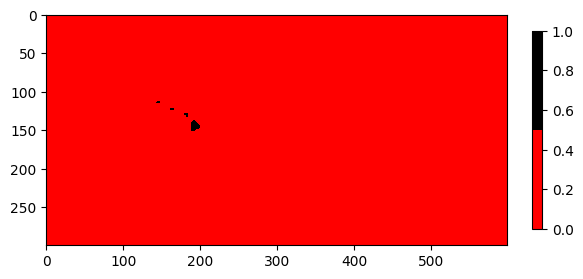

Adjusting learning rate of group 0 to 1.0000e-05.
						Epoch 1 Valid Mean MSE: 672.745
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 1 Train Mean MSE: 259.057
[1e-05]
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 2 Train Mean MSE: 5.24
[1e-05]
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 3 Train Mean MSE: 0.748
[1e-05]
Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 4 Train Mean MSE: 0.348
[1e-05]
Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 5 Train Mean MSE: 0.332
[1.0000000000000002e-06]
Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 6 Train Mean MSE: 0.288
[1.0000000000000002e-06]
Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 7 Train Mean MSE: 0.28
[1.0000000000000002e-06]
Adjusting learning rate of group 0 to 1.0000e-07.
Epoch 8 Train Mean MSE: 0.279
[1.0000000000000002e-07]
Adjusting learning rate of group 0 to 1.0000e-07.
Epoch 9 Train Mean MSE: 0.275
[1.0000000000000002e-07]
Adjusting learning rate of group 0 

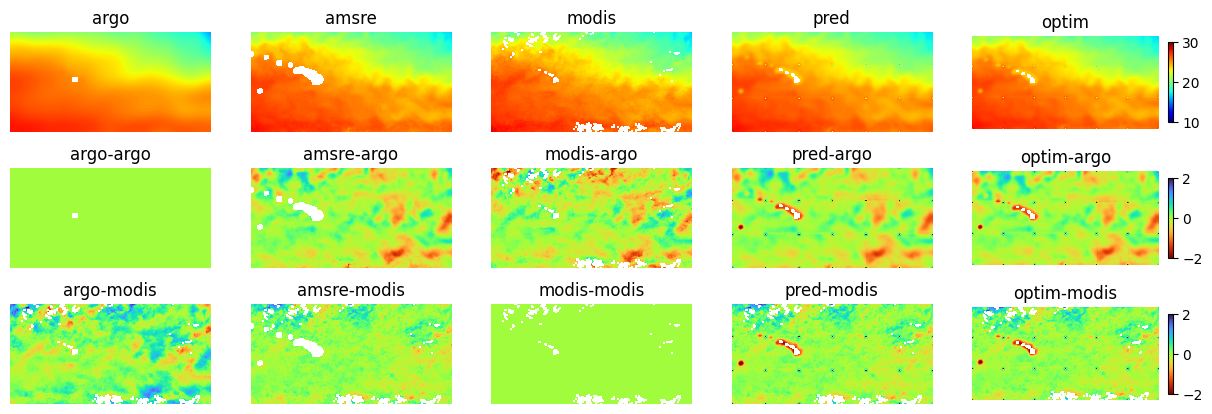

dif between variable and argo
argo		(0.0, tensor(179868))
amsre		(148.27045, tensor(177252))
modis		(178.95718, tensor(179109))
pred		(174.90314, tensor(179803))
optim		(174.90314, tensor(179803))


dif between variable and modis
argo		(178.95718, tensor(179109))
amsre		(117.332214, tensor(176541))
modis		(0.0, tensor(179151))
pred		(157.83496, tensor(179098))
optim		(157.83496, tensor(179098))


AttributeError: 'Tensor' object has no attribute 'GLDAS_mask'

In [14]:

num_epochs=10
patchsize=100
fr = .02

amsre_lox = sorted(glob.glob('../../data/patches/*amsre*.pt'))
modis_lox = sorted(glob.glob('../../data/patches/*modis*.pt'))
argo_lox = sorted(glob.glob('../../data/patches/*argo*.pt'))

blackRed = matplotlib.colors.ListedColormap(['red','black'])

torch.cuda.empty_cache()
print(f'( {torch.cuda.device_count()} ) {torch.cuda.get_device_name(0)} available')


for i in range(9):
    if i in [0,1,2]:
        lat_high = 700
        lat_low = lat_high+300
        lon_left = 100
        lon_right = lon_left+600
    elif i in [3,4,5]:
        lat_high = 1300
        lat_low = lat_high+300
        lon_left = 1500
        lon_right = lon_left+600
    elif i in [6,7,8]:
        lat_high = 800
        lat_low = lat_high+300
        lon_left = 2700
        lon_right = lon_left+600
    amsre_loc=amsre_lox[i]
    
    land_mask = xr.open_dataset('../../data/land_mask.nc')
    land_mask = land_mask.GLDAS_mask[0][lat_high:lat_low,lon_left:lon_right]
    land_mask = xarr2torch(land_mask)
    unfoldobj = torch.nn.Unfold(kernel_size = (patchsize,patchsize),stride=int((patchsize/1)))
    mask_patches = unfoldobj(land_mask).permute(2,0,1).reshape(-1,1,patchsize,patchsize)


    # x,y,z = unfold_fold(land_mask,100,patch_selector=1)
    

    plt.figure()
    plt.imshow(land_mask[0,0],cmap=blackRed)
    plt.colorbar(fraction=fr)
    # plt.imshow(x[0,0],cmap=blackRed)
    plt.pause(0.05)
    
    

    dset = dset_maker(amsre_lox[i],modis_lox[i])
    train_size = int(0.80*len(dset))
    valid_size = int(0.5*(len(dset) - train_size))
    test_size = int(len(dset)-train_size-valid_size)
    train_dset, valid_dset, test_dset = torch.utils.data.random_split(dset,[train_size,valid_size,test_size])
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dset, batch_size=2, shuffle=False, num_workers=0)
    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dset, batch_size=1, shuffle=False, num_workers=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Lnet().to(device)
    model.apply(weights_init)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,8], gamma=.1,verbose=True)


    t0 = A.now('US/Eastern')

    for epoch in range(1, num_epochs + 1):
        if epoch == 1:
            validate(epoch)
        train(epoch)
        if epoch % 10 == 0:
            validate(epoch)
        print(scheduler.get_last_lr())
    t1 = A.now('US/Eastern')

    ds = small_dset_creator(amsre_lox[i],modis_lox[i])
    dl = torch.utils.data.DataLoader(ds,shuffle=False)

    model.eval()
    pred = torch.empty(0,patchsize,patchsize)
    with torch.no_grad():
        for idx,(x,y) in enumerate(dl):
            # target = y-x
            predicted = model(x)
            predicted = predicted.to('cpu')[0,0]
            predicted = torch.from_numpy(np.where(mask_patches[idx,0]>=.49, np.nan,predicted))
            if idx == 0:
                pred = predicted.unsqueeze(0).unsqueeze(1)
            else:
                pred = torch.cat((pred,predicted.unsqueeze(0).unsqueeze(1)),0)



    filter_coast = torch.from_numpy(np.where(np.abs(pred) > np.abs(bandpass(pred)),np.nan,pred))

    ##land mask is key

    argo = torch.load(argo_lox[i])[-1] #-1 selects december

    x0 = foldit(argo) #argo
    x1 = foldit(ds.x0) #amsre
    x2 = foldit(ds.y0) #modis
    x3 = foldit(pred) #pred 
    x4 = foldit(filter_coast) #filtered pred

    xs = [x0,x1,x2,x3,x4]
    nm = ['argo','amsre','modis','pred','optim']

    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(3,5)
    for j in range(5):
        fig.add_subplot(gs[0,j])
        plt.title(nm[j])
        plt.imshow(xs[j][0,0],cmap='jet',vmin=10,vmax=30)
        plt.axis('off')
        if j == 4:
            plt.colorbar(fraction=.02)

        fig.add_subplot(gs[1,j])
        plt.title(f"{nm[j]}-{nm[0]}")
        plt.imshow(xs[j][0,0]-xs[0][0,0],cmap='turbo_r',vmin=-2,vmax=2)
        plt.axis('off')

        if j == 4:
            plt.colorbar(fraction=.02)

        fig.add_subplot(gs[2,j])
        plt.title(f"{nm[j]}-{nm[2]}")
        plt.imshow(xs[j][0,0]-xs[2][0,0],cmap='turbo_r',vmin=-2,vmax=2)
        plt.axis('off')

        if j == 4:
            plt.colorbar(fraction=.02)
    plt.pause(0.05)


    print(f'dif between variable and argo')
    for idk,k in enumerate(xs):
        print(f'{nm[idk]}\t\t{rmse(k,x0)}')

    print('\n')

    print(f'dif between variable and modis')
    for idl,l in enumerate(xs):
        print(f'{nm[idl]}\t\t{rmse(l,x2)}')

( 1 ) NVIDIA GeForce GTX 1080 Ti available


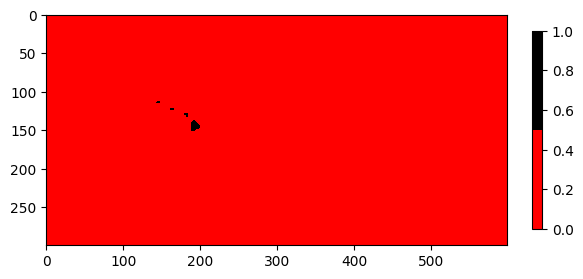

NameError: name 'model' is not defined

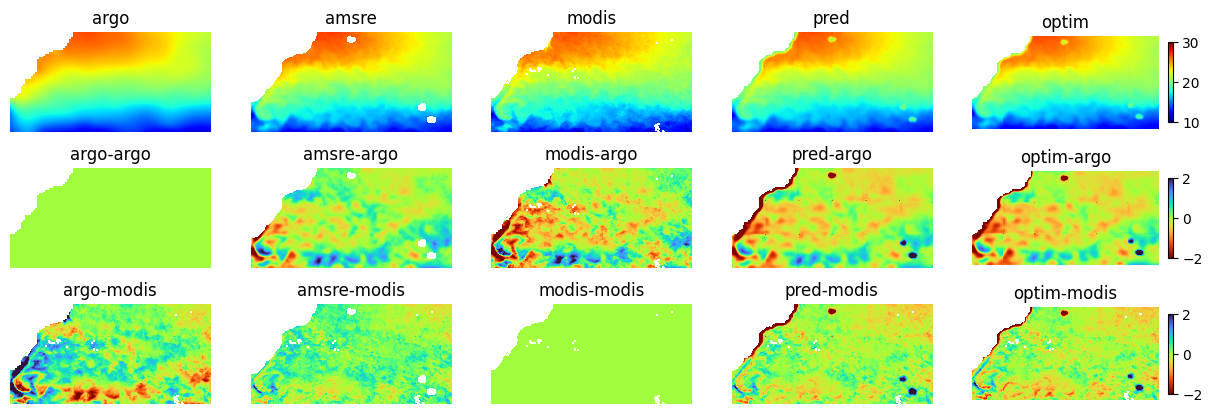

dif between variable and argo
argo		(0.0, tensor(161754))
amsre		(197.81166, tensor(157133))
modis		(276.45584, tensor(161417))
pred		(331.8761, tensor(161360))
optim		(296.11517, tensor(161360))


dif between variable and modis
argo		(276.45584, tensor(161417))
amsre		(156.41086, tensor(157067))
modis		(0.0, tensor(161796))
pred		(276.67078, tensor(161489))
optim		(247.58199, tensor(161489))
